In [ ]:
# contains code from:
# Composer - Apache-2.0 license - Copyright 2022 MosaicML Composer authors

# Fine-Tuning Transformers Performance Tips

To get the most performance out of your GPU when training transformers:

 - Use a fused optimizer
 - Use PyTorch 2.0 compile (if training long enough)

If there isn't a performance degredation:
 - Use Mixed Precision (fp16 or bf16)
 - Use lower precision MatMul (if Ampere or newer GPU)

Also look into:
 - Use a lower precision LayerNorm
 - Use 8-bit Optimizers
 - Flash Attention

## Setup - Run this every time
Import libraries

In [ ]:
import warnings
import pickle
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

import transformers
import datasets
from multiprocessing import cpu_count

from torchmetrics.classification import MulticlassAccuracy
from composer.algorithms import FusedLayerNorm, LowPrecisionLayerNorm
from composer.callbacks import SpeedMonitor
from composer.loggers import ProgressBarLogger, InMemoryLogger
from composer.models.huggingface import HuggingFaceModel
from composer.metrics import CrossEntropy
from composer.optim.scheduler import CosineAnnealingWithWarmupScheduler
from composer.utils import module_surgery
from composer import Trainer

from fastxtend.utils import less_random

APEX = BNB = False

from transformers.utils import logging as hf_logging

warnings.simplefilter('ignore')
hf_logging.set_verbosity_error()

In [ ]:
def plot(logger, labels, save_name=None, load_name=None, color='blue', zoom=False):
    if load_name is None:
        fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,7))
    else:
        fig = pickle.load(open(load_name, 'rb'))
        axs = np.array(fig.axes).reshape(2,2)

    timeseries = logger.get_timeseries('throughput/samples_per_sec')
    train_pct = np.array(timeseries['batch'])/timeseries['batch'][-1]
    axs[0,0].plot(train_pct, timeseries['throughput/samples_per_sec'], color=color)
    axs[0,0].set_xlabel('Train Percent')
    axs[0,0].set_ylabel('Samples Per Second')
    if zoom:
        axs[0,0].set_ylim(260, 290)

    timeseries = logger.get_timeseries('loss/train/total')
    train_pct = np.array(timeseries['batch'])/timeseries['batch'][-1]
    axs[0,1].plot(train_pct, pd.Series(timeseries['loss/train/total']).rolling(25).mean(), color=color)
    axs[0,1].set_xlabel('Train Percent')
    axs[0,1].set_ylabel('Smoothed Loss')

    timeseries = logger.get_timeseries('metrics/train/MulticlassAccuracy')
    train_pct = np.array(timeseries['batch'])/timeseries['batch'][-1]
    axs[1,0].plot(train_pct, pd.Series(timeseries['metrics/train/MulticlassAccuracy']).rolling(25).mean(), color=color)
    axs[1,0].set_xlabel('Train Percent')
    axs[1,0].set_ylabel('Train Accuracy')

    timeseries = logger.get_timeseries('metrics/eval/MulticlassAccuracy')
    axs[1,1].plot(np.array(timeseries['epoch']).astype(str), timeseries['metrics/eval/MulticlassAccuracy'], color=color)
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Eval Accuracy')
    axs[1,1].set_ylim(0.8, 0.915)

    if save_name is not None:
        pickle.dump(fig, open(save_name, 'wb'))
    
    plt.figlegend(labels, loc=5, bbox_to_anchor=(1.145, 0.5))
    
    plt.tight_layout()
    plt.show()

Download and tokenize IMDB

In [ ]:
# Create a BERT sequence classification model using Hugging Face transformers
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')

# Create BERT tokenizer
def tokenize_function(sample):
    return tokenizer(
        text=sample['text'],
        padding='max_length',
        max_length=256,
        truncation=True
    )

# Tokenize IMDB
imdb_dataset = datasets.load_dataset('imdb')
tokenized_imbd_dataset = imdb_dataset.map(tokenize_function,
                                          batched=True,
                                          num_proc=cpu_count(),
                                          batch_size=100)

# Split dataset into train and validation sets
train_dataset = tokenized_imbd_dataset['train']
eval_dataset = tokenized_imbd_dataset['test']

Setup the model

In [ ]:
def create_model(bs=40, lr=1e-4, wd=1e-2, foreach=False, compiler=False, apex_opt=False, 
                 eightbit=False, fused=False, replace=False, fused_ln=False, lp_ln=False, 
                 bnb32=False, subset=200):
    # Create the dataloaders
    data_collator = transformers.data.data_collator.default_data_collator
    with less_random():
        train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True, drop_last=True,
                                      collate_fn=data_collator, num_workers=cpu_count())
    eval_dataloader = DataLoader(eval_dataset, batch_size=bs*2, shuffle=False, drop_last=False,
                                 collate_fn=data_collator, num_workers=cpu_count())

    # Create a Classification BERT
    with less_random():
        model = transformers.AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    # Package as a trainer-friendly Composer model
    metrics = [MulticlassAccuracy(num_classes=2, average='micro')]
    composer_model = HuggingFaceModel(model, tokenizer=tokenizer, metrics=metrics, use_logits=True)

    # Setup optimizer
    if eightbit and BNB:
        if replace:
            policy = {torch.nn.Embedding: _to_StableEmbedding}
            replaced = module_surgery.replace_module_classes(module=composer_model.model, policies=policy)
            if len(replaced)==0:
                print('failed to replace embeddings')
        opt = bnb.optim.Adam8bit if bnb32 is False else bnb.optim.Adam32bit
        optimizer = opt(
            params=composer_model.parameters(),
            lr=lr, betas=(0.9, 0.99),
            eps=1e-6, weight_decay=wd
        )
    elif apex_opt and APEX:
        optimizer = FusedAdam(
            params=composer_model.parameters(),
            lr=lr, betas=(0.9, 0.99),
            eps=1e-6, weight_decay=wd
        )
    else:
        if fused:
            composer_model.to('cuda')
        optimizer = AdamW(
            params=composer_model.parameters(),
            lr=lr, betas=(0.9, 0.99),
            eps=1e-6, weight_decay=wd,
            foreach=foreach, fused=fused
        )

    # Learning rate scheduler
    cos_sched = CosineAnnealingWithWarmupScheduler('0.2dur', '1dur')

    # loggers
    mem_logger = InMemoryLogger()

    # Batch size adjustment
    train_subset = (subset * 40 ) // bs
    eval_subset = (subset * 40) // (bs * 2)

    if fused_ln:
        algorithms = [FusedLayerNorm()]
    elif lp_ln:
        algorithms = [LowPrecisionLayerNorm()]
    else:
        algorithms = []

    # Create Trainer Object
    trainer = Trainer(
        model=composer_model,
        train_dataloader=train_dataloader,
        eval_dataloader=eval_dataloader,
        max_duration='2ep',
        optimizers=optimizer,
        schedulers=[cos_sched],
        device='gpu' if torch.cuda.is_available() else 'cpu',
        callbacks=[SpeedMonitor(window_size=25)],
        loggers=[mem_logger],
        seed=42,
        progress_bar=False,
        train_subset_num_batches=train_subset,
        eval_subset_num_batches=eval_subset,
        compile_config = {} if compiler else None, # comment out this line if Composer is version 0.13.x
        algorithms=algorithms
    )

    return trainer

## Full Precision FP32
Start with full precision training, which is the slowest, but also the most numerically stable.

In [ ]:
trainer = create_model(bs=40)

start = time.perf_counter()

trainer.fit(
    precision='fp32',
    duration='2ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 153.67232635900018


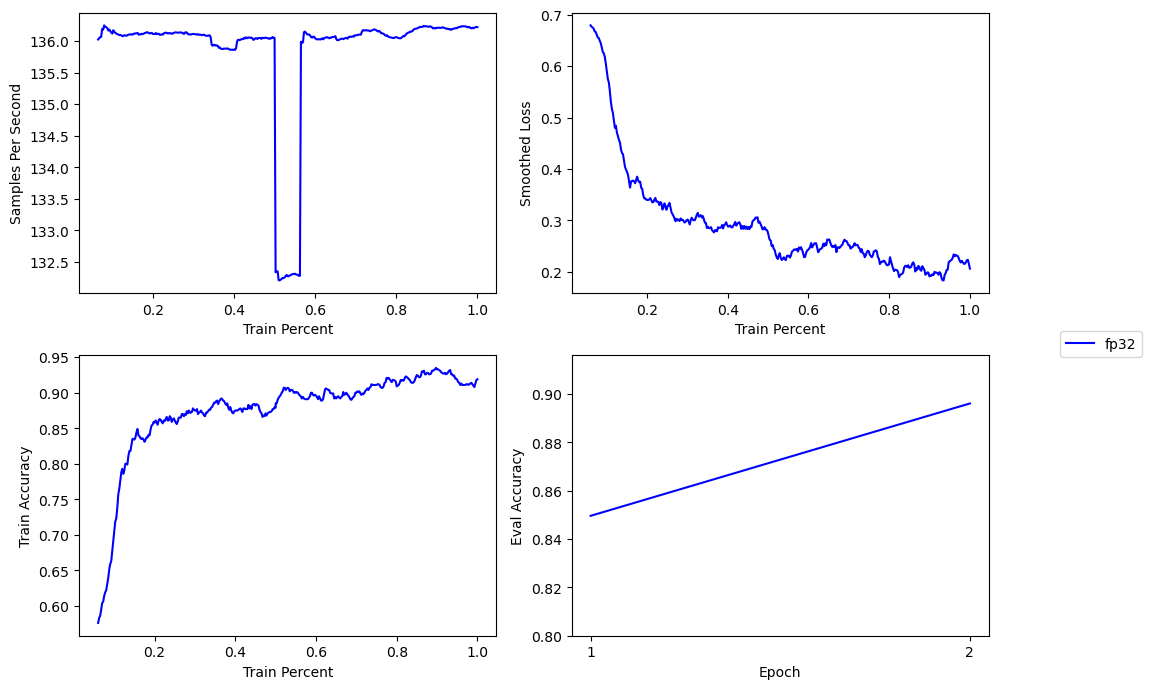

In [ ]:
plot(trainer.logger.destinations[0], ['fp32'], save_name='fp32')

## ForEach Optimizer, FP32


In [ ]:
trainer = create_model(bs=40, foreach=True)

start = time.perf_counter()

trainer.fit(
    precision='fp32',
    duration='2ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 153.08525163000013


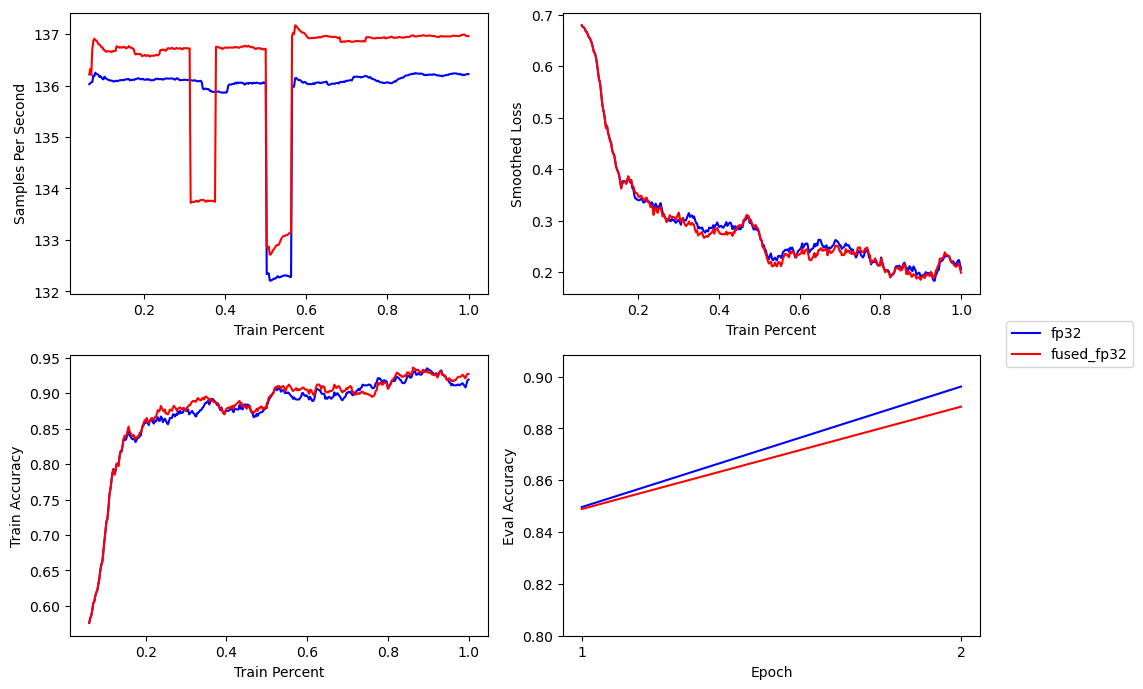

In [ ]:
plot(trainer.logger.destinations[0], ['fp32', 'fused_fp32'], save_name='fused_fp32', load_name='fp32', color='red')

## TensorFloat32 Training

In [ ]:
torch.set_float32_matmul_precision('high')

trainer = create_model(bs=40, foreach=True)

start = time.perf_counter()

trainer.fit(
    precision='fp32',
    duration='2ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 153.05003343000044


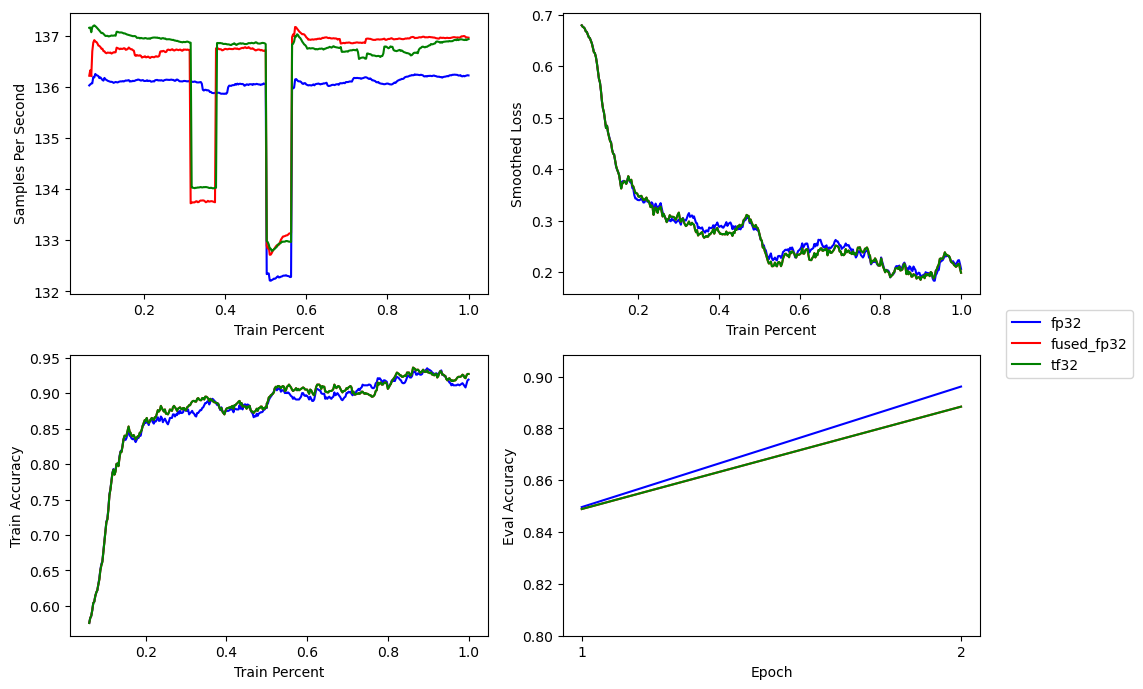

In [ ]:
plot(trainer.logger.destinations[0], ['fp32', 'fused_fp32', 'tf32'], save_name='tf32', load_name='fused_fp32', color='green')

## Mixed Precision (AMP) FP16

In [ ]:
torch.set_float32_matmul_precision('high')

trainer = create_model(bs=40, foreach=True)

start = time.perf_counter()

trainer.fit(
    precision='amp_fp16',
    duration='2ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 104.29053246700005


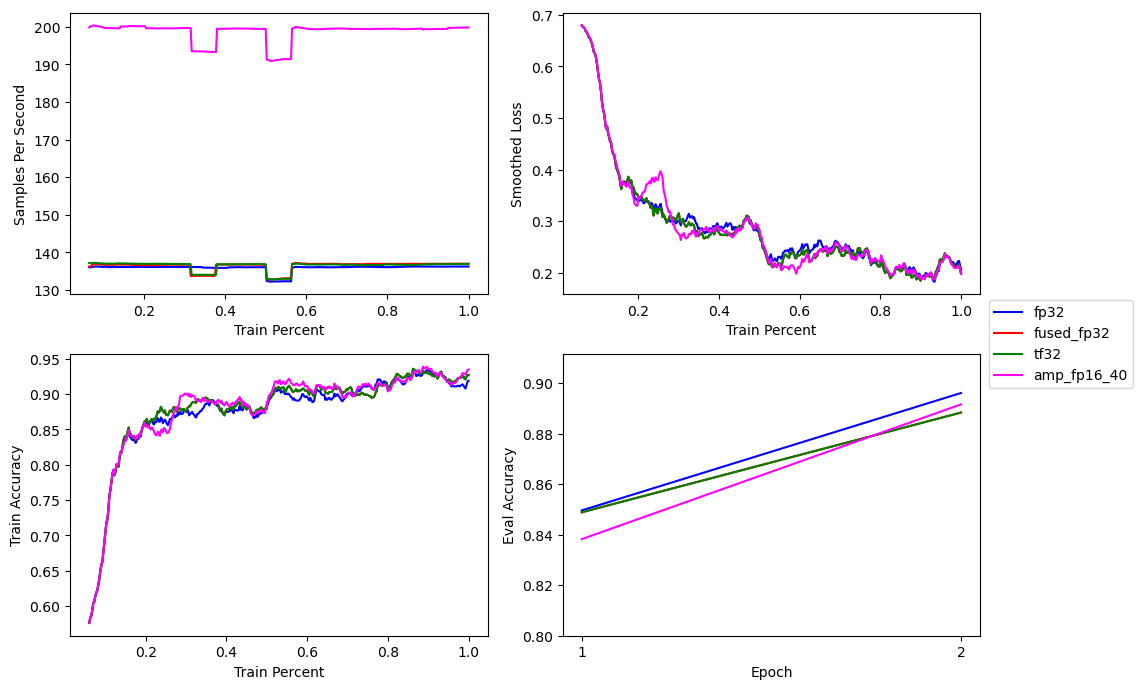

In [ ]:
plot(trainer.logger.destinations[0], ['fp32', 'fused_fp32', 'tf32', 'amp_fp16_40'], save_name='amp_fp16_40', load_name='tf32', color='magenta')

Using Mixed Precision means we can train with a larger batch size.

In [ ]:
torch.set_float32_matmul_precision('high')

trainer = create_model(bs=56, foreach=True, lr=1.5e-4)

start = time.perf_counter()

trainer.fit(
    precision='amp_fp16',
    duration='2ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 100.48823753400029


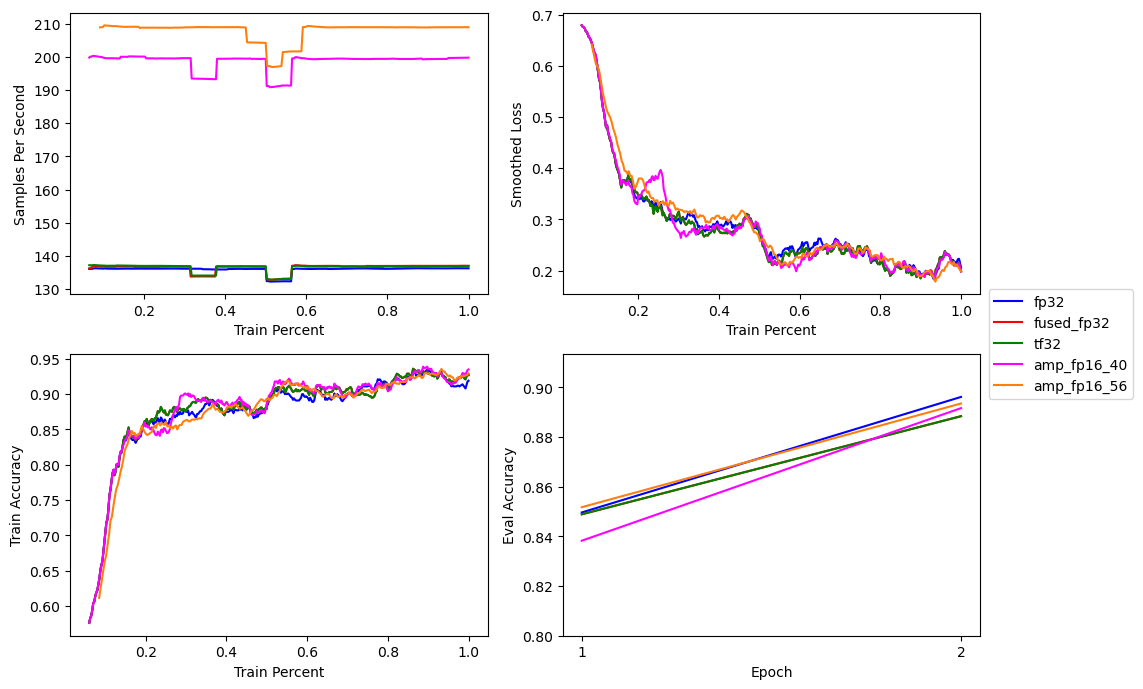

In [ ]:
plot(trainer.logger.destinations[0], ['fp32', 'fused_fp32', 'tf32', 'amp_fp16_40', 'amp_fp16_56'], save_name='amp_fp16_56', load_name='amp_fp16_40', color='tab:orange')

## BFloat16 AMP

In [ ]:
torch.set_float32_matmul_precision('medium')

trainer = create_model(bs=56, foreach=True, lr=1.5e-4)

start = time.perf_counter()

trainer.fit(
    precision='amp_bf16',
    duration='2ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 101.47044412499963


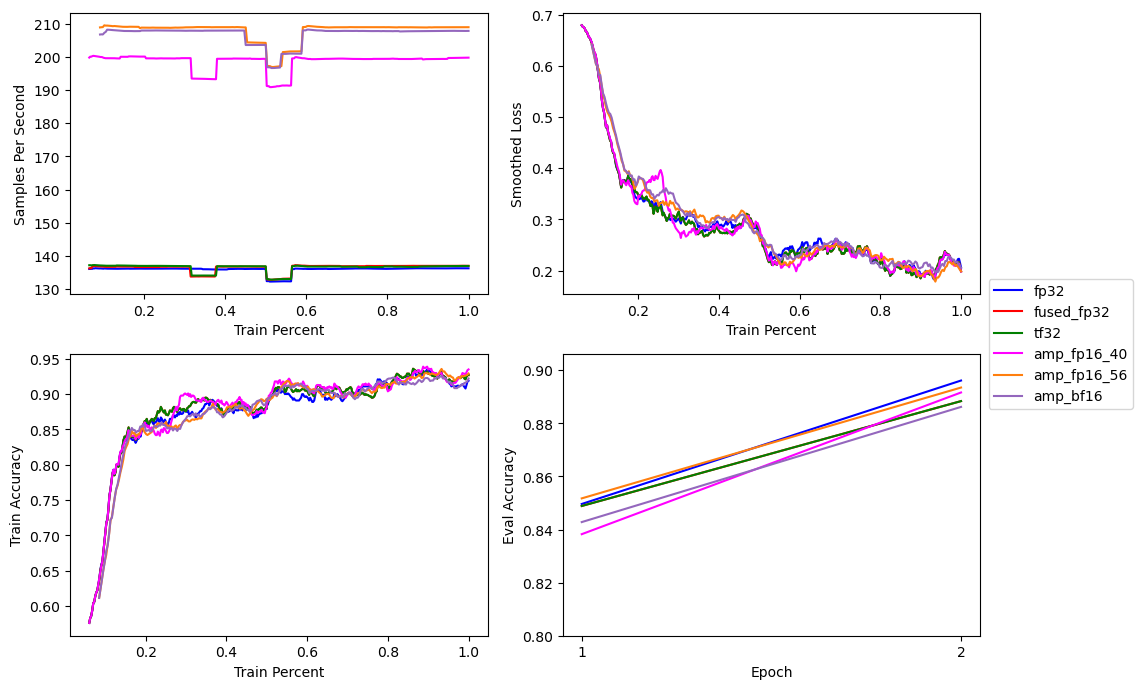

In [ ]:
plot(trainer.logger.destinations[0], ['fp32', 'fused_fp32', 'tf32', 'amp_fp16_40', 'amp_fp16_56', 'amp_bf16'], 
     save_name='amp_bf16', load_name='amp_fp16_56', color='tab:purple')

## PyTorch 2.0 Compile

Using `torch.compile` requires installing the latest version of Composer, 0.14:
```bash
pip install composer
```
this notebook used a development build as 0.14 wasn't released yet.

In [ ]:
torch.set_float32_matmul_precision('high')

trainer = create_model(bs=56, foreach=True, lr=1.25e-4, compiler=True)

start = time.perf_counter()

trainer.fit(
    precision='amp_fp16',
    duration='2ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 106.6736520759996


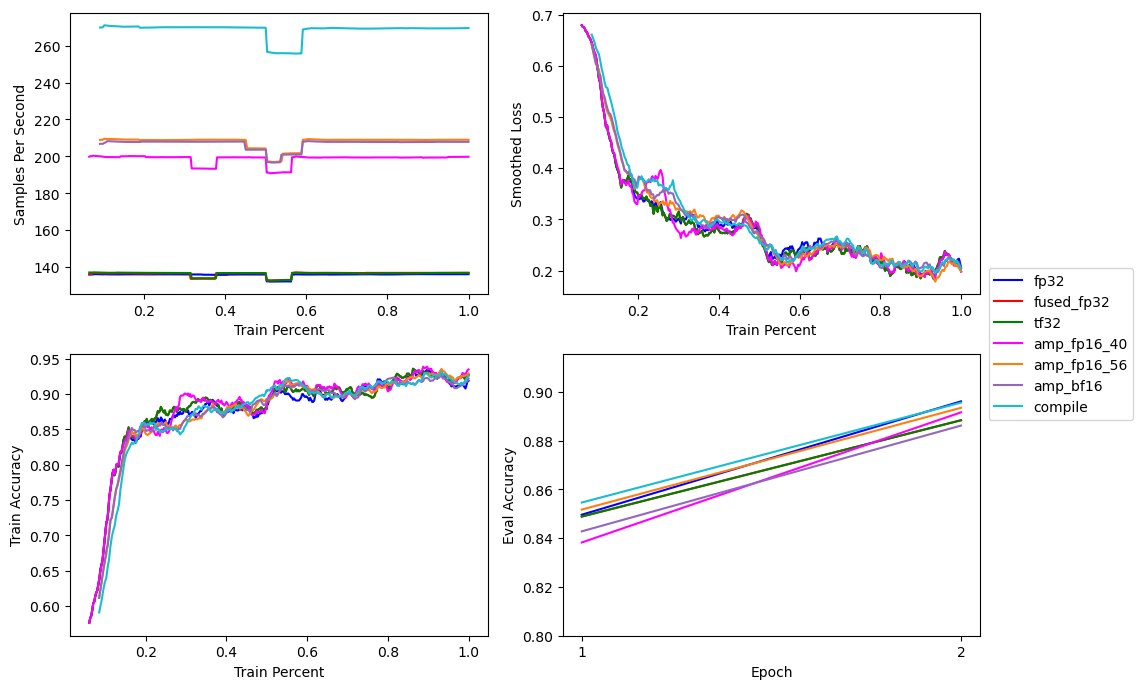

In [ ]:
plot(trainer.logger.destinations[0], ['fp32', 'fused_fp32', 'tf32', 'amp_fp16_40', 'amp_fp16_56', 'amp_bf16', 'compile'], 
     save_name='compile', load_name='amp_bf16', color='tab:cyan')

Using `torch.compile` means we can train with a larger batch size.

In [ ]:
torch.set_float32_matmul_precision('high')

trainer = create_model(bs=64, foreach=True, lr=1.25e-4, compiler=True)

start = time.perf_counter()

trainer.fit(
    precision='amp_fp16',
    duration='2ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 104.60656938300053


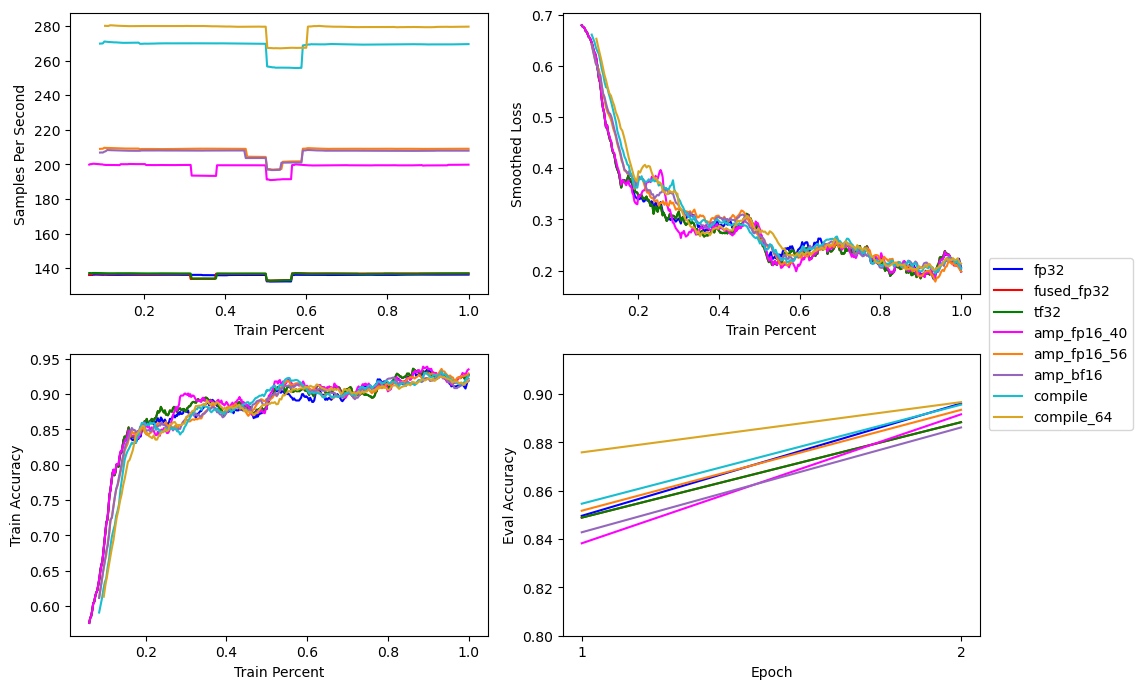

In [ ]:
plot(trainer.logger.destinations[0], ['fp32', 'fused_fp32', 'tf32', 'amp_fp16_40', 'amp_fp16_56', 'amp_bf16', 'compile', 'compile_64'], 
     save_name='compile_64', load_name='compile', color='goldenrod')

## Apex Optimizer

In [ ]:
try:
    import apex.optimizers.FusedAdam as FusedAdam
    APEX = True
except ImportError:
    APEX = False

torch.set_float32_matmul_precision('high')

trainer = create_model(bs=64, lr=1.25e-4, compiler=True, apex_opt=True)

start = time.perf_counter()

trainer.fit(
    precision='amp_fp16',
    duration='2ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 105.03664107100121


Surprisingly, this caused training to slow down. Usually Apex's fully fused optimizers are faster then the ForEach horizontally fused optimizers. Perhaps an issue with PyTorch 2.0 and/or Cuda 11.8.

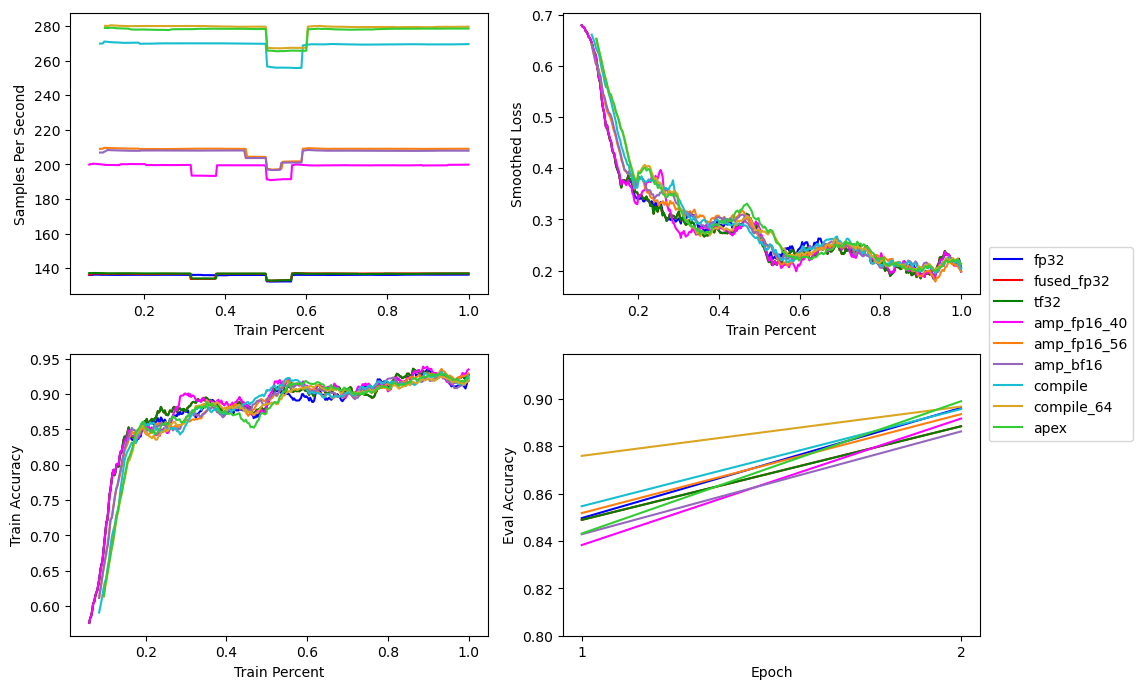

In [ ]:
plot(trainer.logger.destinations[0], ['fp32', 'fused_fp32', 'tf32', 'amp_fp16_40', 'amp_fp16_56', 'amp_bf16', 'compile', 'compile_64', 'apex'], 
     save_name='fp16_apex', load_name='compile_64', color='limegreen')

## Fused LayerNorm

In [ ]:
torch.set_float32_matmul_precision('high')

trainer = create_model(bs=72, lr=1e-4, compiler=True, foreach=True, fused_ln=True)

start = time.perf_counter()

trainer.fit(
    precision='amp_fp16',
    duration='2ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 99.61842097299996


Apex's fused LayerNorm is numerically unstable in BERT Base Uncased.

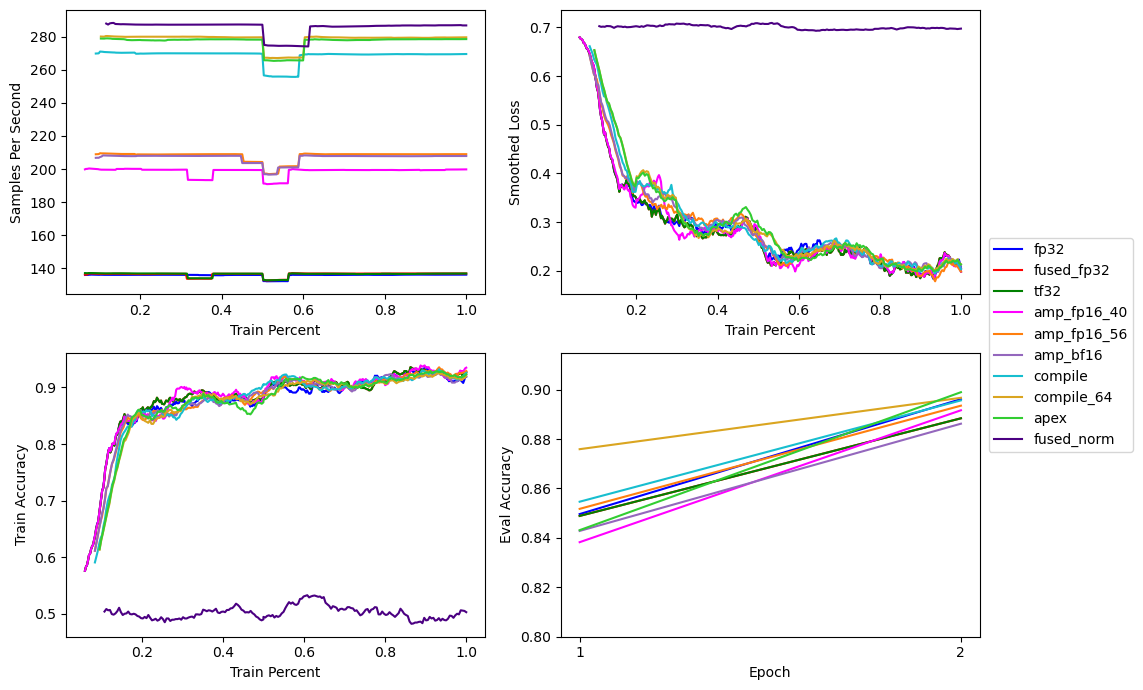

In [ ]:
plot(trainer.logger.destinations[0],
     ['fp32', 'fused_fp32', 'tf32', 'amp_fp16_40', 'amp_fp16_56', 'amp_bf16', 'compile', 'compile_64', 'apex', 'fused_norm'],
     save_name='fused_norm', load_name='fp16_apex', color='indigo')

## Low Precision LayerNorm

In [ ]:
torch.set_float32_matmul_precision('high')

trainer = create_model(bs=72, lr=1.35e-4, compiler=True, foreach=True, lp_ln=True)

start = time.perf_counter()

trainer.fit(
    precision='amp_fp16',
    duration='2ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 106.62620183500076


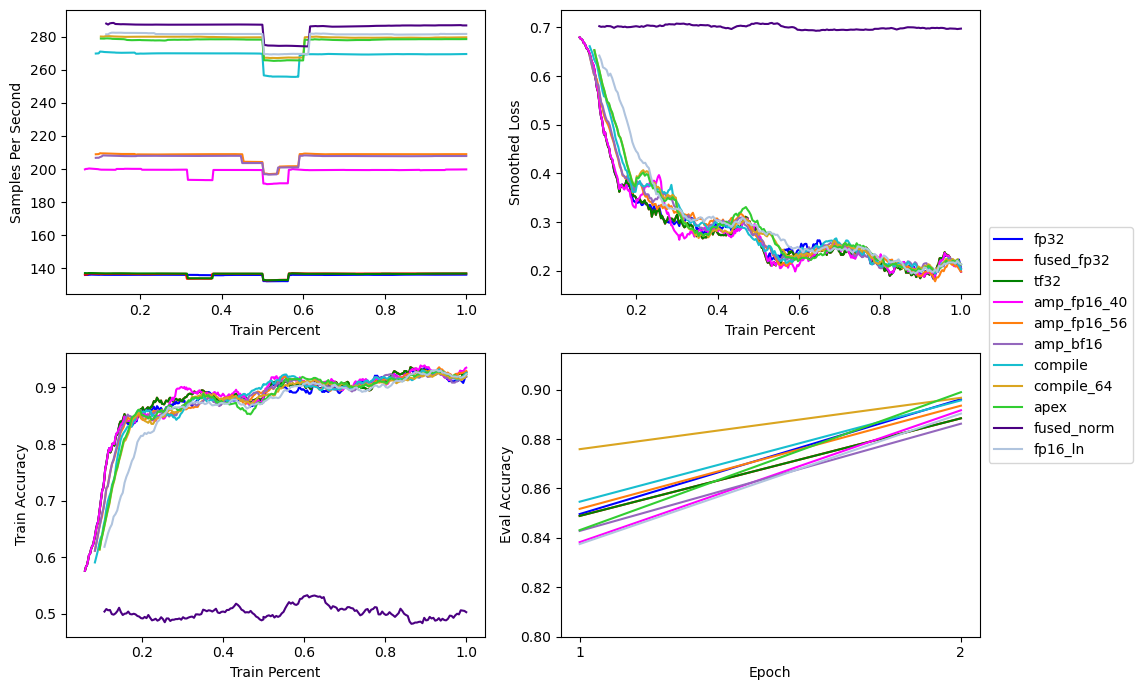

In [ ]:
plot(trainer.logger.destinations[0], 
     ['fp32', 'fused_fp32', 'tf32', 'amp_fp16_40', 'amp_fp16_56', 'amp_bf16', 'compile', 'compile_64', 'apex', 'fused_norm', 'fp16_ln'], 
     save_name='fp16_ln', load_name='fused_norm', color='lightsteelblue')

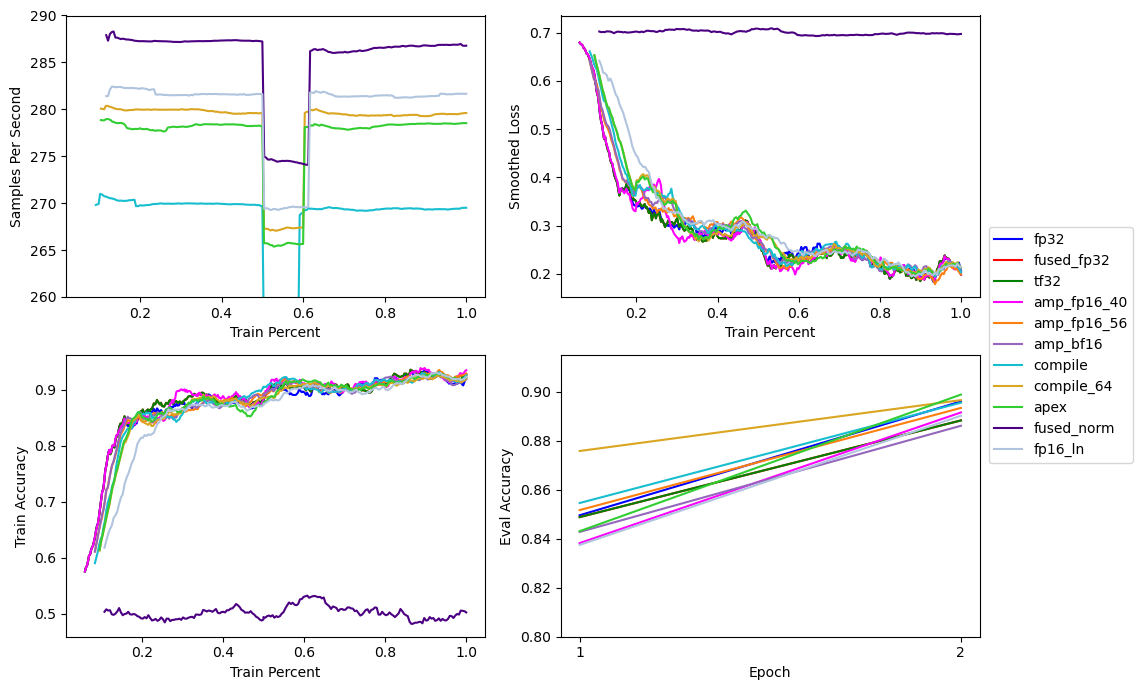

In [ ]:
plot(trainer.logger.destinations[0], 
    ['fp32', 'fused_fp32', 'tf32', 'amp_fp16_40', 'amp_fp16_56', 'amp_bf16', 'compile', 'compile_64', 'apex', 'fused_norm', 'fp16_ln'], 
    save_name='fp16_ln_z', load_name='fused_norm', color='lightsteelblue', zoom=True)

## 8-bit Optimizer

In [ ]:
try:
    import bitsandbytes as bnb
    BNB = True
except ImportError:
    BNB = False

if BNB:
    def _to_StableEmbedding(layer: torch.nn.Module, module_index: int) -> bnb.nn.StableEmbedding:
        "Defines a replacement policy from a `torch.nn.Embedding` to `bnb.nn.StableEmbedding`"
        if not isinstance(layer, torch.nn.Embedding):
            raise TypeError(f'Expected torch.nn.Embedding, got {type(layer)}')
        stable_embedding = bnb.nn.StableEmbedding(layer.num_embeddings, layer.embedding_dim, layer.padding_idx,
                                                 layer.max_norm, layer.norm_type, layer.scale_grad_by_freq,
                                                 layer.sparse)

        with torch.no_grad():
            if layer.weight is None:
                stable_embedding.register_parameter('weight', None)
            else:
                stable_embedding.weight.copy_(layer.weight)  # type: ignore

        return stable_embedding

In [ ]:
torch.set_float32_matmul_precision('high')

trainer = create_model(bs=64, lr=8e-5, compiler=True, eightbit=True, replace=True)

start = time.perf_counter()

trainer.fit(
    precision='amp_bf16',
    duration='2ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 105.4210428059996


8-bit Adam is less numerically stable then the 32-bit AdamW optimizer's we've been using so far.

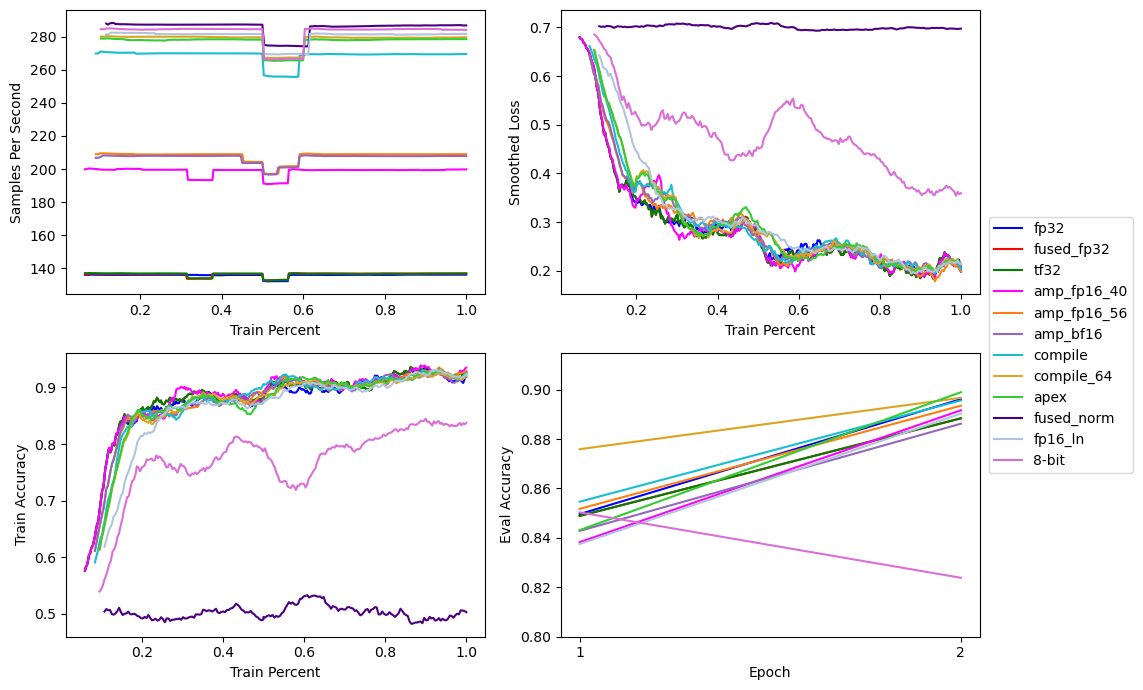

In [ ]:
plot(trainer.logger.destinations[0],
     ['fp32', 'fused_fp32', 'tf32', 'amp_fp16_40', 'amp_fp16_56', 'amp_bf16', 'compile', 'compile_64', 'apex', 'fused_norm', 'fp16_ln', '8-bit'],
     save_name='8-bit', load_name='fp16_ln', color='orchid')

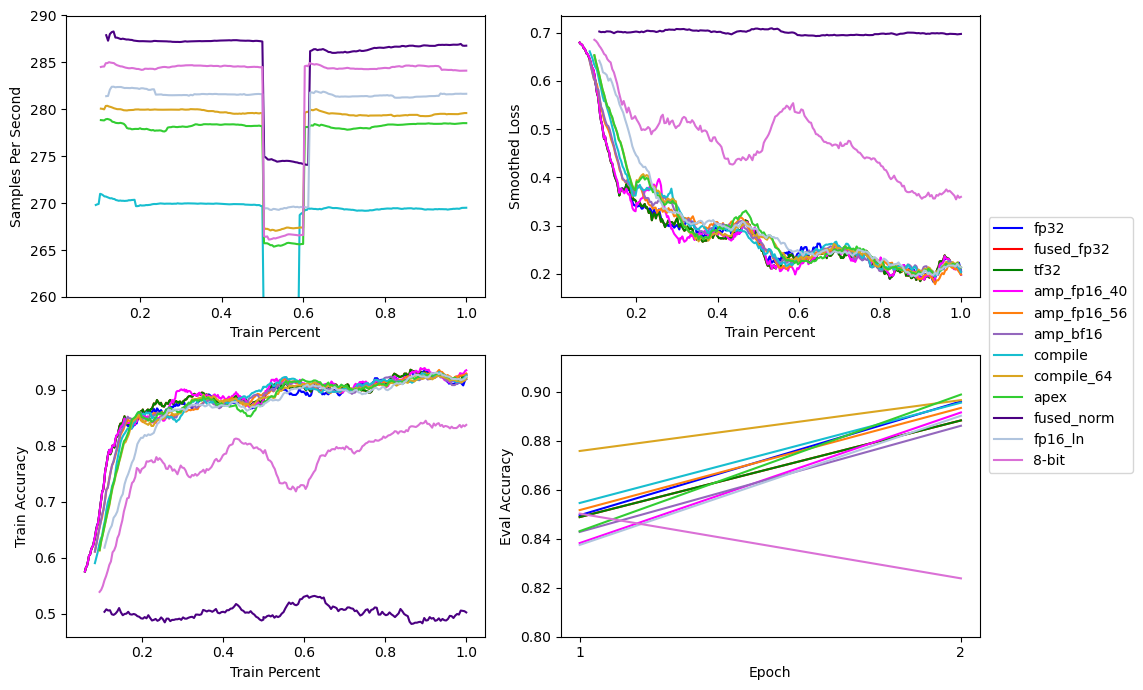

In [ ]:
plot(trainer.logger.destinations[0], 
     ['fp32', 'fused_fp32', 'tf32', 'amp_fp16_40', 'amp_fp16_56', 'amp_bf16', 'compile', 'compile_64', 'apex', 'fused_norm', 'fp16_ln', '8-bit'], 
     save_name='8-bit_z', load_name='fp16_ln_z', color='orchid', zoom=True)

## PyTorch Fused Optimizer

In [ ]:
torch.set_float32_matmul_precision('high')

trainer = create_model(bs=64, fused=True, lr=1.25e-4, compiler=True)

start = time.perf_counter()

trainer.fit(
    precision='amp_fp16',
    duration='2ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 112.51298624100309


PyTorch 2.0 has a fused implementation of Adam, but it appears to have some teething issues.

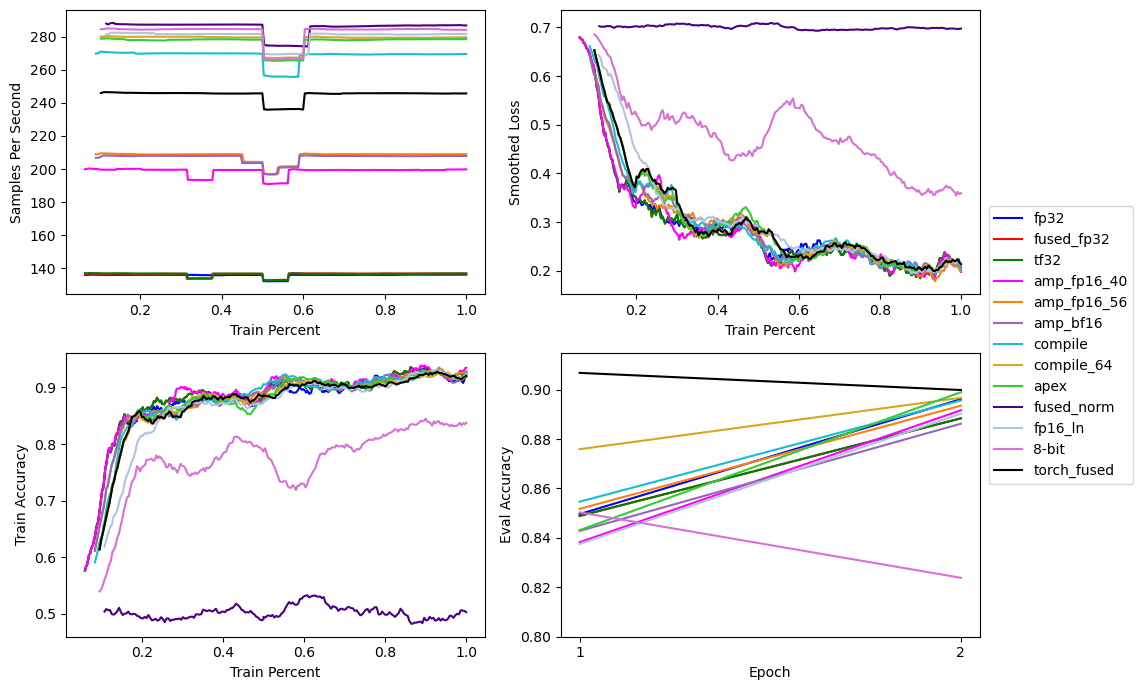

In [ ]:
plot(trainer.logger.destinations[0],
     ['fp32', 'fused_fp32', 'tf32', 'amp_fp16_40', 'amp_fp16_56', 'amp_bf16', 'compile', 'compile_64', 'apex', 'fused_norm', 'fp16_ln', '8-bit', 'torch_fused'],
     save_name='pytorch_fused', load_name='8-bit', color='black')

## BNB 32-bit Fused

In [ ]:
torch.set_float32_matmul_precision('high')

trainer = create_model(bs=64, eightbit=True, bnb32=True, lr=1.25e-4, compiler=True)

start = time.perf_counter()

trainer.fit(
    precision='amp_fp16',
    duration='2ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 105.58142089499961


BitsAndBite's 32-bit fused optimizer is still slower then the ForEach fused optimizer.

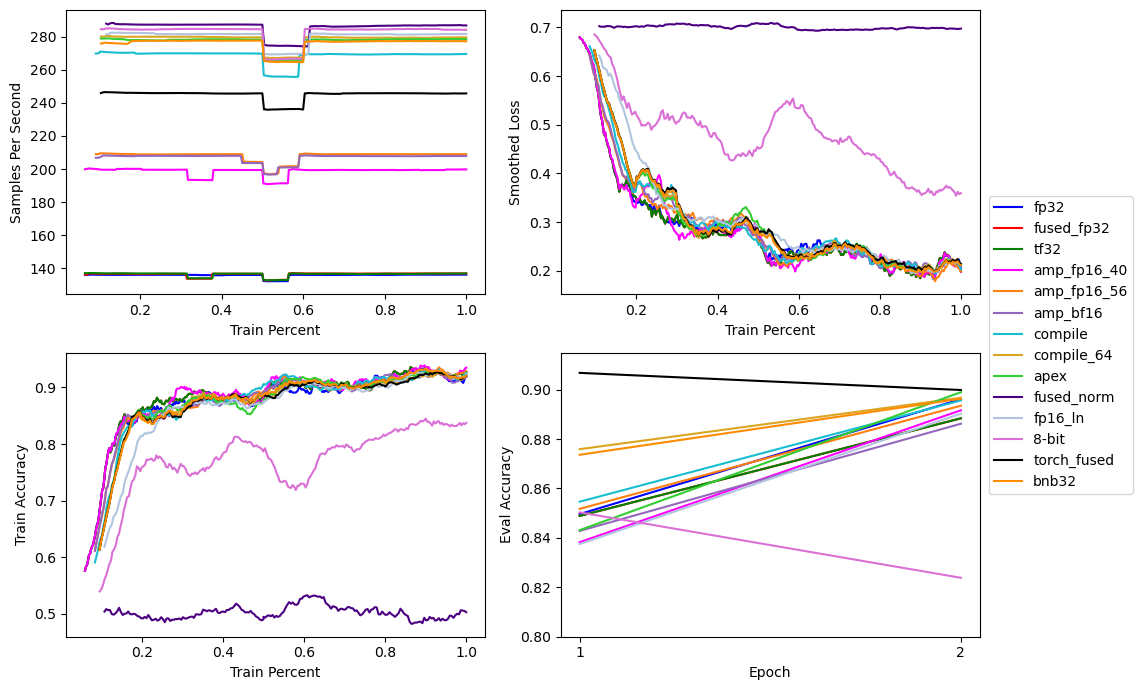

In [ ]:
plot(trainer.logger.destinations[0],
     ['fp32', 'fused_fp32', 'tf32', 'amp_fp16_40', 'amp_fp16_56', 'amp_bf16', 'compile', 'compile_64', 'apex', 'fused_norm', 'fp16_ln', '8-bit', 'torch_fused', 'bnb32'], 
     save_name='bnb32', load_name='pytorch_fused', color='darkorange')

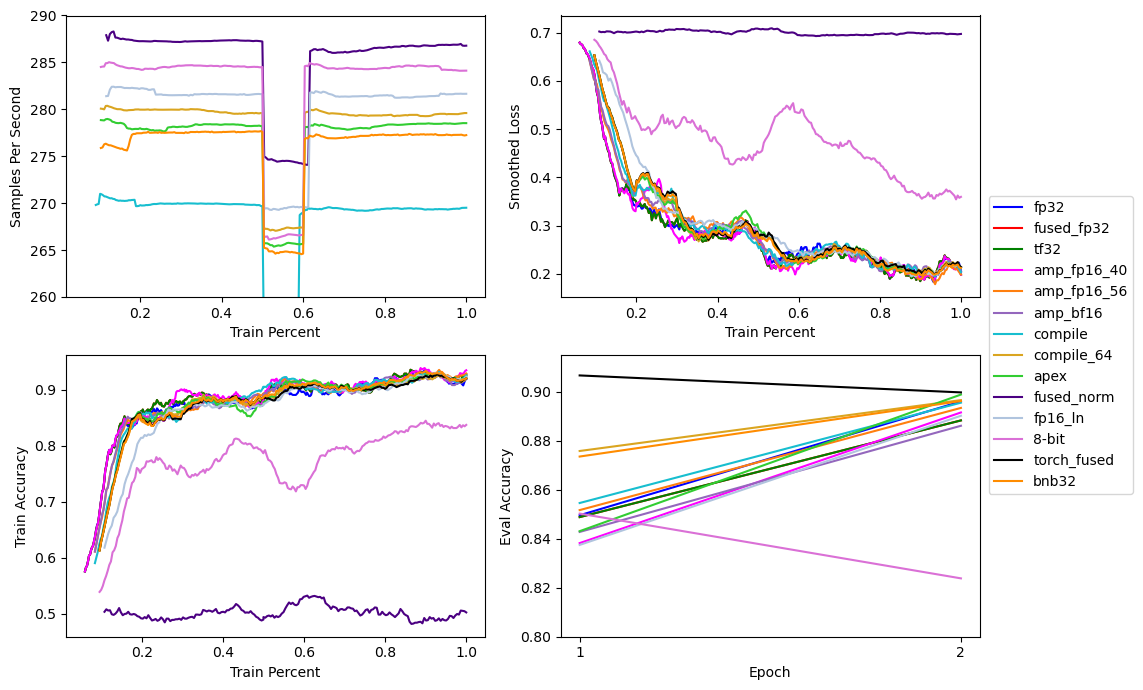

In [ ]:
plot(trainer.logger.destinations[0],
     ['fp32', 'fused_fp32', 'tf32', 'amp_fp16_40', 'amp_fp16_56', 'amp_bf16', 'compile', 'compile_64', 'apex', 'fused_norm', 'fp16_ln', '8-bit', 'torch_fused', 'bnb32'], 
     save_name='bnb32_z', load_name='pytorch_fused', color='darkorange', zoom=True)

## 8-bit Optimizer + LP LN

In [ ]:
try:
    import bitsandbytes as bnb
    BNB = True
except ImportError:
    BNB = False

if BNB:
    def _to_StableEmbedding(layer: torch.nn.Module, module_index: int) -> bnb.nn.StableEmbedding:
        "Defines a replacement policy from a `torch.nn.Embedding` to `bnb.nn.StableEmbedding`"
        if not isinstance(layer, torch.nn.Embedding):
            raise TypeError(f'Expected torch.nn.Embedding, got {type(layer)}')
        stable_embedding = bnb.nn.StableEmbedding(layer.num_embeddings, layer.embedding_dim, layer.padding_idx,
                                                 layer.max_norm, layer.norm_type, layer.scale_grad_by_freq,
                                                 layer.sparse)

        with torch.no_grad():
            if layer.weight is None:
                stable_embedding.register_parameter('weight', None)
            else:
                stable_embedding.weight.copy_(layer.weight)  # type: ignore

        return stable_embedding

In [ ]:
torch.set_float32_matmul_precision('high')

trainer = create_model(bs=64, lr=8e-5, compiler=True, eightbit=True, replace=True, lp_ln=True)

start = time.perf_counter()

trainer.fit(
    precision='amp_bf16',
    duration='2ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 108.0526601040001


8-bit Adam plus low precision LayerNorm is the second fastest, only falling behind fused LayerNorm. But like 8-bit Adam, it is also numerically unstable.

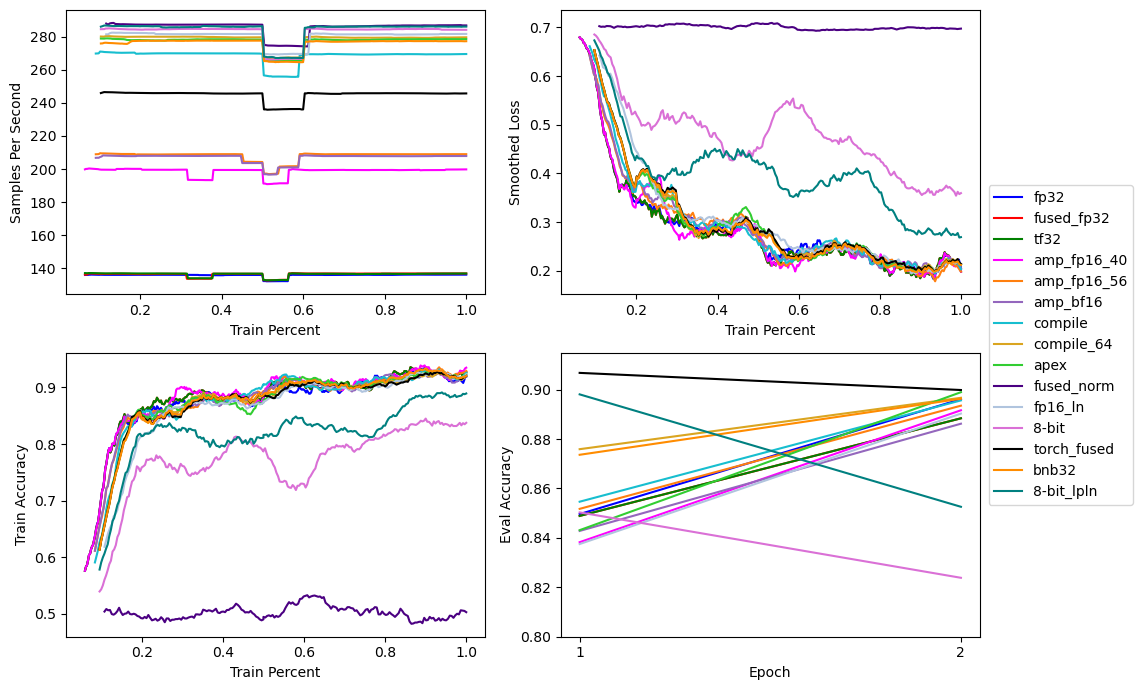

In [ ]:
plot(trainer.logger.destinations[0],
     ['fp32', 'fused_fp32', 'tf32', 'amp_fp16_40', 'amp_fp16_56', 'amp_bf16', 'compile', 'compile_64', 'apex', 'fused_norm', 'fp16_ln', '8-bit', 'torch_fused', 'bnb32', '8-bit_lpln'],
     save_name='8-bit_lpln', load_name='bnb32', color='teal')

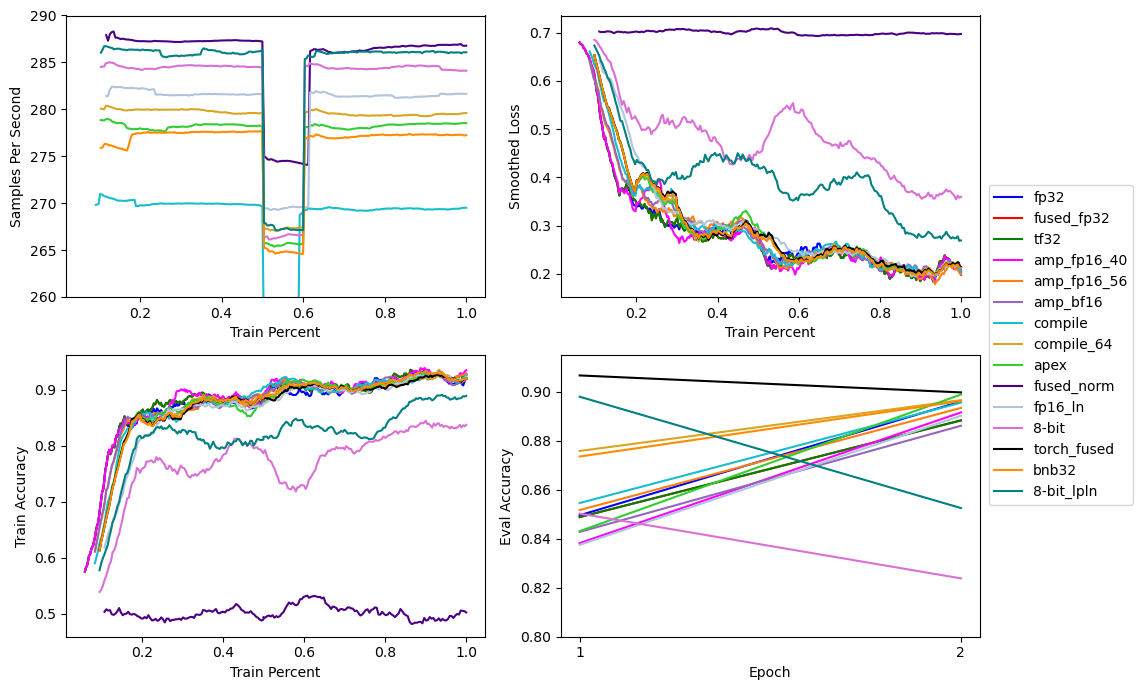

In [ ]:
plot(trainer.logger.destinations[0], 
     ['fp32', 'fused_fp32', 'tf32', 'amp_fp16_40', 'amp_fp16_56', 'amp_bf16', 'compile', 'compile_64', 'apex', 'fused_norm', 'fp16_ln', '8-bit', 'torch_fused', 'bnb32', '8-bit_lpln'],  
     save_name='8-bit_lpln_z', load_name='bnb32', color='teal', zoom=True)

## Flash Attention
This section was ran with Composer 0.14 instead of dev.

### Setup - Run this every time

In [ ]:
import warnings
import pickle
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

import transformers
import datasets
from multiprocessing import cpu_count

from torchmetrics.classification import MulticlassAccuracy
from composer.algorithms import FusedLayerNorm, LowPrecisionLayerNorm
from composer.callbacks import SpeedMonitor
from composer.loggers import ProgressBarLogger, InMemoryLogger
from composer.models.huggingface import HuggingFaceModel
from composer.metrics import CrossEntropy
from composer.optim.scheduler import CosineAnnealingWithWarmupScheduler
from composer.utils import module_surgery
from composer import Trainer

from fastxtend.utils import less_random

APEX = BNB = False

from transformers.utils import logging as hf_logging

warnings.simplefilter('ignore')
hf_logging.set_verbosity_error()

In [ ]:
def plot(logger, labels, save_name=None, load_name=None, color='blue', zoom=False):
    if load_name is None:
        fig, axs = plt.subplots(ncols=2, figsize=(10,3.5))
    else:
        fig = pickle.load(open(load_name, 'rb'))
        axs = np.array(fig.axes).reshape(2)

    timeseries = logger.get_timeseries('throughput/samples_per_sec')
    train_pct = np.array(timeseries['batch'])/timeseries['batch'][-1]
    axs[0].plot(train_pct, timeseries['throughput/samples_per_sec'], color=color)
    axs[0].set_xlabel('Train Percent')
    axs[0].set_ylabel('Samples Per Second')
    if zoom:
        axs[0].set_ylim(260, 290)

    timeseries = logger.get_timeseries('loss/train/total')
    train_pct = np.array(timeseries['batch'])/timeseries['batch'][-1]
    axs[1].plot(train_pct, pd.Series(timeseries['loss/train/total']).rolling(25).mean(), color=color)
    axs[1].set_xlabel('Train Percent')
    axs[1].set_ylabel('Smoothed Loss')

    if save_name is not None:
        pickle.dump(fig, open(save_name, 'wb'))

    plt.figlegend(labels, loc=5, bbox_to_anchor=(1.145, 0.5))

    plt.tight_layout()
    plt.show()

In [ ]:
# Tokenizing adapted from https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
# Transformers - Apache-2.0 license

from itertools import chain

# Create a BERT sequence classification model using Hugging Face transformers
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')

max_seq_length = 256

# Create BERT tokenizer
def tokenize_function(sample):
    return tokenizer(sample['text'], return_special_tokens_mask=True)

# Main data processing function that will concatenate all texts from our dataset and generate chunks of
# max_seq_length.
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= max_seq_length:
        total_length = (total_length // max_seq_length) * max_seq_length
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + max_seq_length] for i in range(0, total_length, max_seq_length)]
        for k, t in concatenated_examples.items()
    }
    return result

# tokenize entire dataset without throwing any tokens away
imdb_dataset = datasets.load_dataset('imdb')['train']
tokenized_datasets = imdb_dataset.map(
    tokenize_function,
    batched=True,
    num_proc=cpu_count(),
    remove_columns=['text', 'label'],
    batch_size=200,
)

# resplit dataset to be max size lenght samples
train_dataset = tokenized_datasets.map(
    group_texts,
    batched=True,
    num_proc=cpu_count(),
    batch_size=200,
)

In [ ]:
# Transformers - Apache-2.0 license

from fastcore.foundation import patch
import math
import torch.nn as nn
from torch.backends.cuda import sdp_kernel
import torch.nn.functional as F
from transformers.models.bert.modeling_bert import BertForMaskedLM,  BertSelfAttention, BertAttention, BertSelfOutput
from typing import Optional, Tuple
try:
    # Prevents torch.compile from graph breaking on einops functions. Requires einops>=0.6.1
    # https://github.com/arogozhnikov/einops/wiki/Using-torch.compile-with-einops
    # Was using for testing flash_attn, don't think HF Bert uses `rearrange`
    from einops._torch_specific import allow_ops_in_compiled_graph
    allow_ops_in_compiled_graph()
except ImportError:
    pass

class FlashBertSelfAttention(BertSelfAttention):
    def __init__(self, config, position_embedding_type=None):
        super().__init__(config, position_embedding_type)
        self.flash = getattr(config, 'use_flash_attention', False)
        self.attn_drop = config.attention_probs_dropout_prob

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        if self.flash:
            with sdp_kernel(True, False, False):
                context_layer = F.scaled_dot_product_attention(query_layer, key_layer, value_layer)
        else:
            use_cache = past_key_value is not None
            if self.is_decoder:
                # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
                # Further calls to cross_attention layer can then reuse all cross-attention
                # key/value_states (first "if" case)
                # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
                # all previous decoder key/value_states. Further calls to uni-directional self-attention
                # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
                # if encoder bi-directional self-attention `past_key_value` is always `None`
                past_key_value = (key_layer, value_layer)

            # Take the dot product between "query" and "key" to get the raw attention scores.
            attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

            if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
                query_length, key_length = query_layer.shape[2], key_layer.shape[2]
                if use_cache:
                    position_ids_l = torch.tensor(key_length - 1, dtype=torch.long, device=hidden_states.device).view(
                        -1, 1
                    )
                else:
                    position_ids_l = torch.arange(query_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
                position_ids_r = torch.arange(key_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
                distance = position_ids_l - position_ids_r

                positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
                positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

                if self.position_embedding_type == "relative_key":
                    relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                    attention_scores = attention_scores + relative_position_scores
                elif self.position_embedding_type == "relative_key_query":
                    relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                    relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                    attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

            attention_scores = attention_scores / math.sqrt(self.attention_head_size)
            if attention_mask is not None:
                # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
                attention_scores = attention_scores + attention_mask

            # Normalize the attention scores to probabilities.
            attention_probs = nn.functional.softmax(attention_scores, dim=-1)

            # This is actually dropping out entire tokens to attend to, which might
            # seem a bit unusual, but is taken from the original Transformer paper.
            attention_probs = self.dropout(attention_probs)

            # Mask heads if we want to
            if head_mask is not None:
                attention_probs = attention_probs * head_mask

            context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs

@patch
def __init__(self:BertAttention, config, position_embedding_type=None):
    super(BertAttention, self).__init__()
    self.self = FlashBertSelfAttention(config, position_embedding_type=position_embedding_type)
    self.output = BertSelfOutput(config)
    self.pruned_heads = set()

In [ ]:
from transformers import BertConfig

def create_mlm(bs=32, lr=5e-5, wd=1e-2, foreach=False, compiler=False, flash_attn=False):
    # Create the dataloaders
    data_collator = transformers.DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)
    with less_random():
        train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True, drop_last=True,
                                      collate_fn=data_collator, num_workers=cpu_count())

    # Create a Masked Language Modeling BERT
    with less_random():
        config = BertConfig.from_pretrained('bert-base-uncased')
        if flash_attn:
            config.use_flash_attention = True
        model = BertForMaskedLM(config)

    # Package as a trainer-friendly Composer model
    composer_model = HuggingFaceModel(model, tokenizer=tokenizer)

    # Setup optimizer
    optimizer = AdamW(
        params=composer_model.parameters(),
        lr=lr, betas=(0.9, 0.99),
        eps=1e-6, weight_decay=wd,
        foreach=foreach,
    )

    # Learning rate scheduler
    cos_sched = CosineAnnealingWithWarmupScheduler('0.25dur', '1dur')

    # loggers
    mem_logger = InMemoryLogger()

    # Create Trainer Object
    trainer = Trainer(
        model=composer_model,
        train_dataloader=train_dataloader,
        max_duration='1ep',
        optimizers=optimizer,
        schedulers=[cos_sched],
        device='gpu' if torch.cuda.is_available() else 'cpu',
        callbacks=[SpeedMonitor(window_size=25)],
        loggers=[mem_logger],
        seed=42,
        progress_bar=False,
        compile_config = {} if compiler else None, # comment out this line if Composer is version 0.13.x
    )

    return trainer

### AMP
AMP and foreach

In [ ]:
torch.set_float32_matmul_precision('high')

trainer = create_mlm(compiler=False)

start = time.perf_counter()

trainer.fit(
    precision='amp_fp16',
    duration='1ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 187.8336839299991


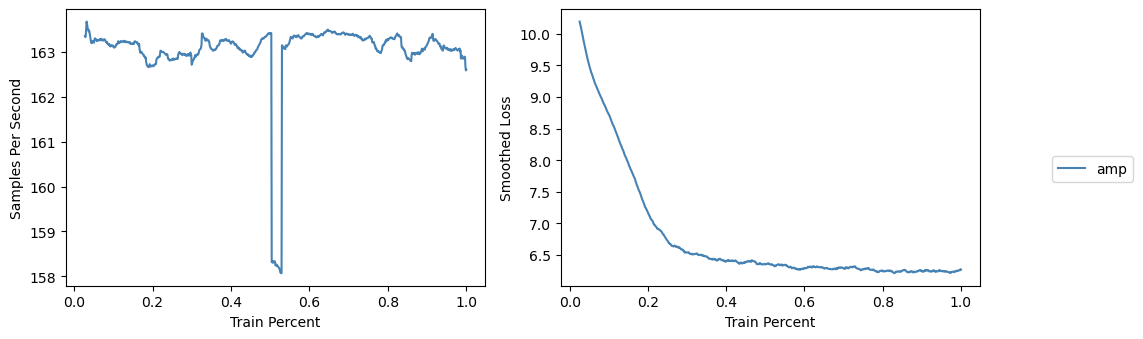

In [ ]:
plot(trainer.logger.destinations[0], ['amp'], save_name='mlm_amp', color='steelblue')

### Compile
AMP, foreach, and compile

In [ ]:
torch.set_float32_matmul_precision('high')

trainer = create_mlm(compiler=True)

start = time.perf_counter()

trainer.fit(
    precision='amp_fp16',
    duration='1ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 171.08690222699988


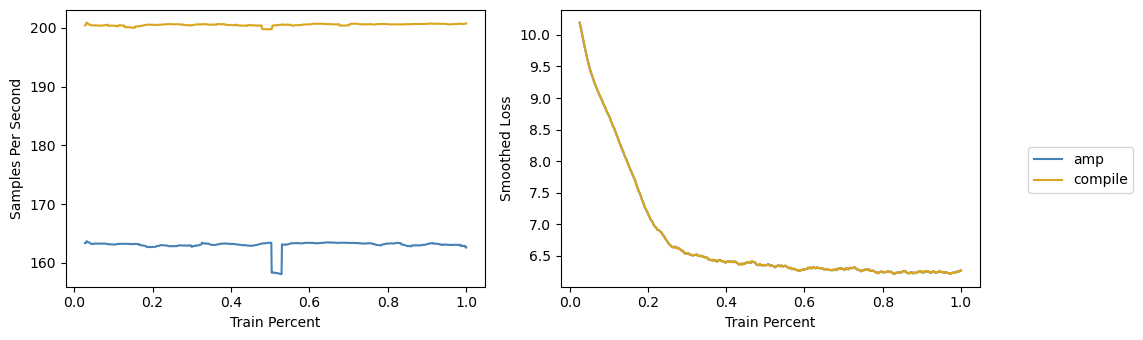

In [ ]:
plot(trainer.logger.destinations[0], ['amp', 'compile'], save_name='mlm_compile', load_name='mlm_amp', color='goldenrod')

### Flash Attention
AMP and foreach, with flash attention

In [ ]:
torch.set_float32_matmul_precision('high')

trainer = create_mlm(compiler=False, bs=40, flash_attn=True, lr=7.5e-5)

start = time.perf_counter()

trainer.fit(
    precision='amp_fp16',
    duration='1ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 146.6032119420015


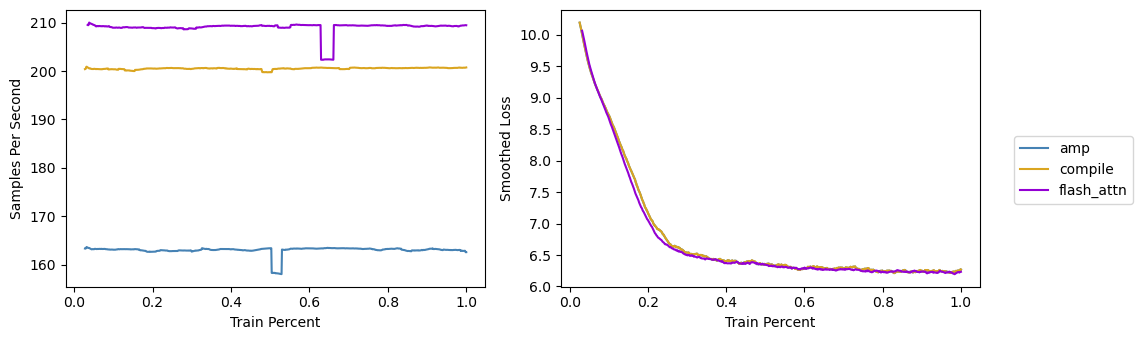

In [ ]:
plot(trainer.logger.destinations[0], ['amp', 'compile', 'flash_attn'], save_name='mlm_flash', load_name='mlm_compile', color='darkviolet')

### Compile + Flash Attention

In [ ]:
torch.set_float32_matmul_precision('high')

trainer = create_mlm(compiler=True, bs=48, flash_attn=True, lr=1e-4)

start = time.perf_counter()

trainer.fit(
    precision='amp_fp16',
    duration='1ep',
)

total = time.perf_counter() - start
print(f'total time: {total}')

total time: 152.47276543499902


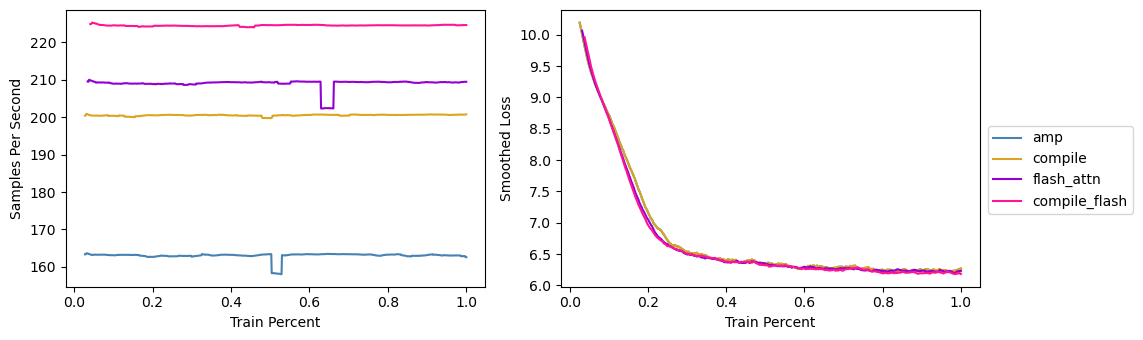

In [ ]:
plot(trainer.logger.destinations[0], ['amp', 'compile', 'flash_attn', 'compile_flash'], save_name='mlm_flash_compile', load_name='mlm_flash', color='deeppink')